In [24]:
import os
import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage import io
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
df = pd.read_csv('class1.csv')

df_train, df_val = train_test_split(df, test_size=.2)

df_train.shape, df_val.shape

((49262, 4), (12316, 4))

In [27]:
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

          
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)


def get_image(path, x1,y1, shape, crop_size):

    x = cv2.imread(path)
    
    x = cv2.cvtColor(x,cv2.COLOR_BGR2GRAY)

    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]

    x = resize(x, shape)

    x = x/255.

    return x

    

def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):

    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2

    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2

   

    sel = dataframe.values

    ids = sel[:,0].astype(int).astype(str)

    y_batch = sel[:,1:]

    x_batch = []

    for i in tqdm(ids):

        x = get_image('./images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)

        x_batch.append(x)

    x_batch = np.array(x_batch)

    return x_batch, y_batch

        

X_train, y_train = get_all_images(df_train)

X_val, y_val = get_all_images(df_val)

100%|██████████| 12316/12316 [01:12<00:00, 171.01it/s]


In [30]:
X_train.shape

(49262, 64, 64)

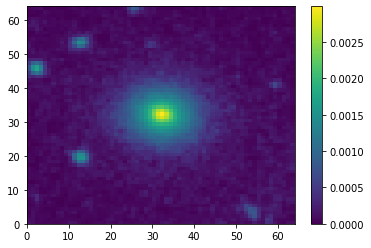

In [33]:
plt.pcolormesh(X_train[1,:,:])
plt.colorbar()

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

In [7]:
X_train.shape

(49262, 64, 64, 3)

In [36]:
X_train = np.array(X_train).reshape((49262, 64*64))

In [37]:
X_train.shape

(49262, 4096)

In [10]:
#x = np.zeros(X_train.shape)#X_train.shape = tuple
#X_train = x[:, :, 0]
#print(X_train.shape)

(49262, 4096)


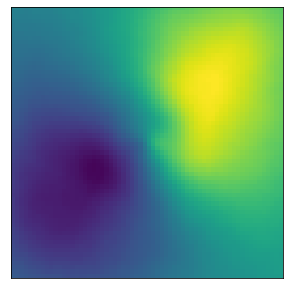

In [38]:
from sklearn import decomposition
n_components = 5
(n_samples, n_features) = X_train.shape
estimator = decomposition.PCA(n_components=n_components, svd_solver='randomized', whiten=True)
estimator.fit(X_train)
components_ = estimator.components_
images = components_[:n_components]
plt.figure(figsize=(6, 5))
for i, comp in enumerate(images):
    vmax = max(comp.max(), -comp.min())
    plt.imshow(comp.reshape((64, 64)),interpolation='nearest',vmin=-vmax, vmax=vmax)
    plt.xticks(())
    plt.yticks(())
plt.savefig('graph.png')
plt.show()



In [39]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [40]:
d

297

In [41]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (49262, 297)
recovered shape: (49262, 4096)


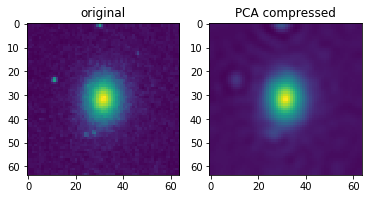

In [42]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((64,64)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

In [45]:
clf_reduced = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20))
clf_reduced.fit(X_reduced, y_train)

ValueError: Multioutput target data is not supported with label binarization

In [ ]:
X_test_reduced = pca.transform(X_test)
y_hat_reduced = clf_reduced.predict(X_test_reduced)

print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))